# Recurrent Neural Networks for Time Series Forecasting: LTSM (Darts Package)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os

import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter()

from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, Theta
from darts.metrics import mse, mape, rmse, mase, smape, mae
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from DataExploration.BitbrainsUtils import load_VM
FIGURES_PATH = '../Figures/Modeling'
from darts import TimeSeries


import sys
import time
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

[2022-02-23 15:55:43,840] WARNING | darts.models | Support for AutoARIMA is not available.To enable it, install u8darts[pmdarima] or u8darts[all].
[2022-02-23 15:55:43,841] WARNING | darts.models | Support for Facebook Prophet is not available. To enable it, install "darts", "u8darts[prophet]" or "u8darts[all]" (with pip);or "u8darts-all" (with conda).


figures saved to ../Figures/DataExploration/


# Prepare the Source Data

In [2]:
# Load data
VM = load_VM('917.csv')
series = TimeSeries.from_dataframe(VM, value_cols='CPU usage [MHZ]', freq='5T')
ts = series

In [3]:
# replace 0 and NaN by backfilling
s = series.pd_series()
s.replace(0.0, np.nan, inplace=True)
s = s.fillna(method="bfill")
series = series.from_series(s)
ts = series

## Data exploration

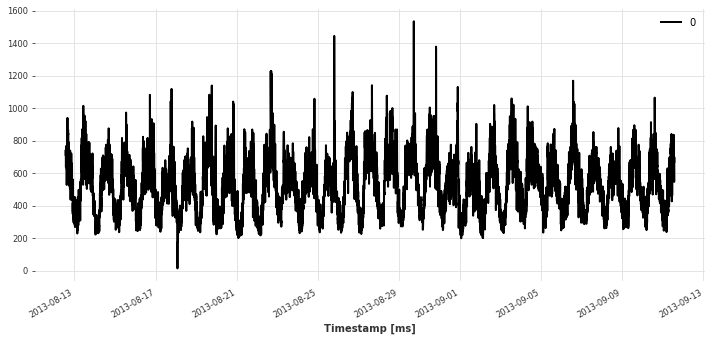

In [4]:
import matplotlib
# matplotlib.use('TkAgg')
# matplotlib.use('MacOSX')
# plot the observations
plt.figure(figsize=(12, 5))
ts.plot()
plt.show()

In [5]:
# analyze its seasonality
is_seasonal, periodicity = check_seasonality(series, max_lag=300)
dict_seas ={
    "is seasonal?":is_seasonal, 
    "periodicity (Timestamps)":f'{periodicity:.1f}',
    "periodicity (~Hours)": f'{periodicity*5/60:.1f}'}
_ = [print(k,":",v) for k,v in dict_seas.items()]

is seasonal? : True
periodicity (Timestamps) : 286.0
periodicity (~Hours) : 23.8


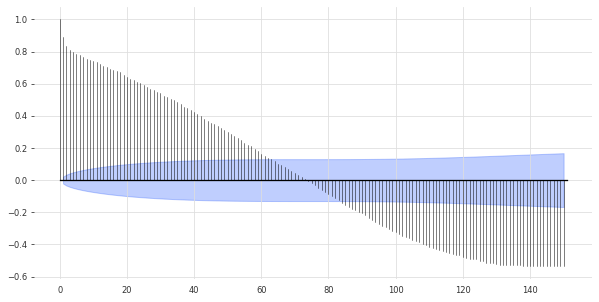

In [6]:
# plot its autocorrelation function
plot_acf(series, max_lag=150)

## Data preprocessing

In [7]:
# split training vs test dataset
FC_SPLIT = 0.9          # period at which to split training and validation dataset
train, val = ts.split_after(FC_SPLIT)

In [8]:
# normalize the time series
trf = Scaler()
# fit the transformer to the training dataset
train_trf = trf.fit_transform(train)
# apply the transformer to the validation set and the complete series 
val_trf = trf.transform(val)
ts_trf = trf.transform(ts)

In [9]:
# create day and hours covariate series
day_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), 
        freq=ts.freq_str, 
        periods=len(ts)),
    attribute='day',
    one_hot=False)
day_series = Scaler().fit_transform(day_series)

hour_series = datetime_attribute_timeseries(
    day_series,
    attribute='hour',
    one_hot=True)

covariates = day_series.stack(hour_series)
cov_train, cov_val = covariates.split_after(FC_SPLIT)

## Modeling

In [20]:
# Hyper-parameters
EPOCH = 20
MODEL = 'LSTM'
NAME = 'with_co'
INPUT_CHUNK_LENGTH = 288
FORECASTING_HORIZON = 288*3
HIDDEN_DIM = 20
N_LAYERS = 1
DROPOUT = 0
LR = 1e-3

In [21]:
 # set the model up
LTSM_model = RNNModel(
    model=MODEL,
    model_name=MODEL+NAME,
    input_chunk_length=INPUT_CHUNK_LENGTH,
    training_length=INPUT_CHUNK_LENGTH,
    hidden_dim=HIDDEN_DIM,
    n_rnn_layers=N_LAYERS,
    batch_size=16,
    n_epochs=EPOCH,
    dropout=DROPOUT,
    optimizer_kwargs={'lr': LR},
    nr_epochs_val_period=1,
    log_tensorboard=True,
    random_state=42,
    force_reset=True,
    save_checkpoints=True)

In [22]:
# Fit the model
t_start =  time.perf_counter()
print("\nBeginning the training")
res = LTSM_model.fit(
         train_trf,
         future_covariates=covariates,
         val_series=val_trf,
         val_future_covariates=covariates,
         verbose=True)
res_time = time.perf_counter() - t_start
print("Training has completed:", f'{res_time:.2f} sec')


Beginning the training


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training has completed: 244.77 sec


### Look at predictions at the validation set

In [25]:
def eval_model(model):
    pred_series = model.predict(n=FORECASTING_HORIZON, future_covariates=covariates)
    fig = plt.figure(figsize=(8, 5), dpi=150)
    ts_trf.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_trf)))
    plt.legend()
    # Saving figure
    savefig='LSTM/Features'
    if not os.path.exists(os.path.join(FIGURES_PATH, savefig)):
        os.makedirs(os.path.join(FIGURES_PATH, savefig))
    save_path = os.path.join(FIGURES_PATH, savefig, NAME)
    plt.savefig(save_path, bbox_inches='tight')
    plt.close(fig)

    # Metrics
    res_mape = mape(val_trf, pred_series)
    res_mae = mae(val_trf, pred_series)
    res_mse = mse(val_trf, pred_series)
    res_rmse = rmse(val_trf, pred_series)
    res_smape = smape(val_trf, pred_series)
    res_mase = mase(val_trf, pred_series,train_trf)
    res_accuracy = {"MAPE":res_mape, "MASE":res_mase, "MAE":res_mae, "RMSE":res_rmse, "MSE":res_mse,"SMAPE": res_smape, "time":res_time}

    results = [pred_series, res_accuracy]
    return results

In [26]:
%matplotlib inline
model_predictions = eval_model(LTSM_model)

Predicting: 468it [00:00, ?it/s]

In [27]:
# Take best model
best_model = RNNModel.load_from_checkpoint(model_name=MODEL+NAME, best=True)
eval_model(best_model)

Predicting: 0it [00:00, ?it/s]

[<TimeSeries (DataArray) (Timestamp [ms]: 864, component: 1, sample: 1)>
 array([[[0.32427439]],
 
        [[0.33679596]],
 
        [[0.34282494]],
 
        [[0.34526913]],
 
        [[0.34646901]],
 
        [[0.34715819]],
 
        [[0.34752494]],
 
        [[0.34764352]],
 
        [[0.34758059]],
 
        [[0.34740004]],
 
 ...
 
        [[0.42668961]],
 
        [[0.42668982]],
 
        [[0.42669001]],
 
        [[0.42669021]],
 
        [[0.4266904 ]],
 
        [[0.4266906 ]],
 
        [[0.42669079]],
 
        [[0.42669097]],
 
        [[0.42669116]],
 
        [[0.42669134]]])
 Coordinates:
   * Timestamp [ms]  (Timestamp [ms]) datetime64[ns] 2013-09-08T13:40:00 ... 2...
   * component       (component) object '0'
 Dimensions without coordinates: sample,
 {'MAPE': 31.789834021129693,
  'MASE': 2.2207161503471644,
  'MAE': 0.08570613610655482,
  'RMSE': 0.10980458964004047,
  'MSE': 0.012057047906017682,
  'SMAPE': 24.934920774352317,
  'time': 244.77383283300014}]

In [28]:
metrics = pd.DataFrame.from_dict(model_predictions[1], orient='index')
try:
    filename = os.path.join('darts_logs',str(MODEL+NAME),'metrics.txt')
    file = open(filename, 'wt')
    file.write(str(metrics))
    file.close()

except:
    print("Unable to write to file")
metrics

,0
MAPE,33.566337
MASE,2.327408
MAE,0.089824
RMSE,0.113029
MSE,0.012775
SMAPE,26.287278
time,244.773833


### Backtesting

In [ ]:
backtest_series = LTSM_model.historical_forecasts(
    ts_trf,
    future_covariates=covariates,
    start=0.8,
    forecast_horizon=288*3,
    retrain=False,
    verbose=False,
)

MAPE: 13.12%


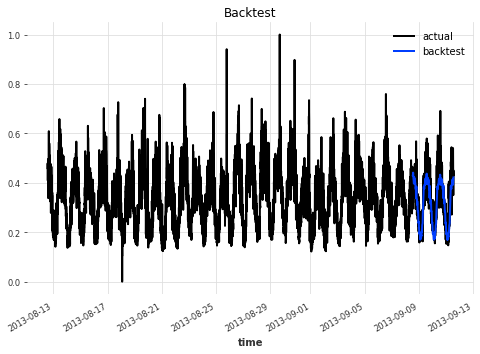

In [28]:
plt.figure(figsize=(8, 5))
ts_trf.plot(label="actual")
backtest_series.plot(label="backtest")
plt.legend()
plt.title("Backtest")
print(
    "MAPE: {:.2f}%".format(
        mape(
            trf.inverse_transform(ts_trf),
            trf.inverse_transform(backtest_series),
        )
    )
)

# Compare with the Theta method

Theta forecast has completed:  4.45 sec
MAPE : 16.1069
RMSPE : 0.1938
RMSE : 100.1816
-R squared : -0.4182
se : 10.2523


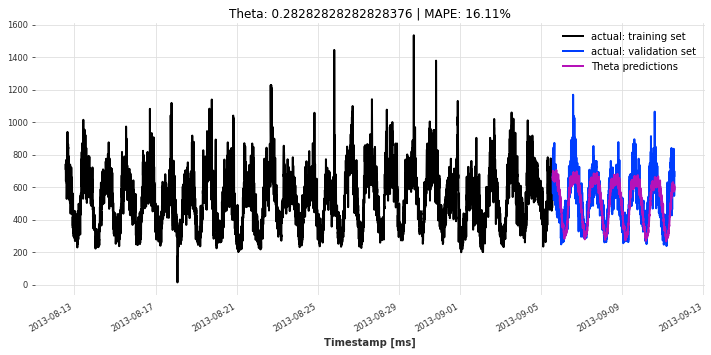

In [19]:
# Theta forecaster

# search space for best theta value: check 100 alternatives
thetas = 2 - np.linspace(-10, 10, 100)

# initialize search
best_mape = float('inf')
best_theta = 0
t_start =  time.perf_counter()
# search for best theta among 100 values, as measured by MAPE
for theta in thetas:
    model = Theta(theta)
    res = model.fit(train)
    pred_theta = model.predict(len(val))
    res_mape = mape(val, pred_theta)
    if res_mape < best_mape:
        best_mape = res_mape
        best_theta = theta


# fit the model
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred = best_theta_model.predict(len(val))

# review the Theta results
plt.figure(figsize=(12,5))
train.plot(label='actual: training set')
val.plot(label='actual: validation set')
pred.plot(label='Theta predictions')
plt.title("Theta: {0}".format(best_theta) + ' | MAPE: {:.2f}%'.format(mape(pred, val)))
plt.legend();

res_time = time.perf_counter() - t_start
res_acc = accuracy_metrics(pred, val)
print("Theta forecast has completed: ", f'{res_time:.2f} sec')
_ = [print(k,":",f'{v:.4f}') for k,v in res_acc.items()]
results = [pred, res_acc]


In [20]:
# collect the forecasters's accuracy metrics in a dataframe

dict_models = {"LSTM":res_flavors[0][1], "GRU":res_flavors[1][1],
    "Vanilla":res_flavors[2][1], "Theta":res_acc}
df_acc = pd.DataFrame.from_dict(dict_models, orient="index").T
pd.set_option("display.precision",3)
df_acc.style.highlight_min(color="lightgreen", axis=1).highlight_max(color="yellow", axis=1)

IndexError: list index out of range